In [73]:
import torch
import numpy as np
from ademamix import AdEMAMix
from lion import Lion
from focus import FOCUS

seed = 7
torch.manual_seed(seed)
np.random.seed(seed)

# get task vectors. all orthogonal
dim = 10
n_task = 100

# n_task = 10 can easily see why AdEMAMix accelerates with old momentum

gaus = torch.randn(dim, dim)
#u, s, v = torch.svd(gaus)

'''u = torch.randn(2, dim)/torch.sqrt(torch.tensor(dim))
gamma = - 0.5
u[1] = u[1] + gamma * u[0] '''


# sweep noise scale is the most important 
# Lion performs worse when noise is large

# power law distribution
alpha = 1
prob = 1/(np.arange(n_task) + 1)**(alpha)
prob /= np.sum(prob)

'''prob1 = 0.9
prob = [prob1] + list(prob * (1-prob1))
prob = np.array(prob)
n_task += 1'''

noise_scale = 0.1 # maybe due to non-linearity

u = torch.randn(n_task, dim)/torch.sqrt(torch.tensor(dim))
task_vectors = u[:n_task]


batch_size = 128

# initial and target
x = torch.nn.Parameter(torch.zeros(dim,))

learning_rate = 0.01
#optimizer = torch.optim.SGD([x], lr=learning_rate)
#optimizer = torch.optim.Adam([x], lr=learning_rate, betas=(0.9,0.95))
#optimizer = AdEMAMix([x], lr=learning_rate)
optimizer = FOCUS([x], lr=learning_rate, betas=(0.9,0.99), gamma=1.0)
#optimizer = Lion([x], lr=learning_rate)
target = torch.sum(task_vectors, dim=0)


n_steps = 15000
log = 1000
task_abilities = []
losses = []
losses_skill = []
n_uses = []


for i in range(n_steps):
    
    '''if i == 5000:
        for g in optimizer.param_groups:
            g['lr'] = 0.006 #0.003
            noise_scale = 0.0 #0.0
        #batch_size = 512
    if i == 6000:
        for g in optimizer.param_groups:
            g['lr'] = 0.01
            noise_scale = 0.1'''
    
    '''if i < 100:
        for g in optimizer.param_groups:
            g['lr'] = 0.01/100 * (i+1)'''

    optimizer.zero_grad()

    # project and get progress
    task_overlap = task_vectors @ x
    task_ability = torch.sigmoid(task_overlap)
    
    loss = np.sum(-np.log(task_ability.detach().numpy()) * prob)
    task_abilities.append(task_ability.detach().numpy())
    losses.append(loss)
    losses_skill.append(1 - task_ability.detach().numpy())

    # mimic gradient
    id = np.random.choice(n_task, batch_size, p=prob)
    task_vectors_batch = task_vectors[id]
    task_ability_batch = task_ability[id]
    
    #neg_grad_per_sample = (1-task_ability_batch).unsqueeze(dim=1)
    #neg_grad_per_sample = torch.abs(1-task_ability_batch).unsqueeze(dim=1) ** (1) * torch.sign((1-task_ability_batch).unsqueeze(dim=1))

    #neg_grad = torch.mean(task_vectors_batch*neg_grad_per_sample, dim=0)
    loss_per_sample = -torch.log(task_ability_batch)
    
    if i < 20000:
        loss = torch.mean(loss_per_sample)
    else:
        loss = torch.mean(loss_per_sample * (0.1+loss_per_sample.detach())**(-0.5))
    loss.backward()
    x.grad.data += noise_scale * torch.randn(dim,)
    
    # update 
    #x.grad = - neg_grad + torch.randn(dim) * noise_scale
    optimizer.step()
    
    neg_grad = - x.grad.detach()
    
    # compute #(used dimension)
    alignment = task_vectors * neg_grad[None, :] > 0
    n_used = torch.sum(alignment, dim=1)
    n_uses.append(n_used.detach().numpy())
    
    if i % log == 0:
        print(i)

task_abilities = np.array(task_abilities)
losses = np.array(losses)
n_uses = np.array(n_uses)
losses_skill = np.array(losses_skill)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


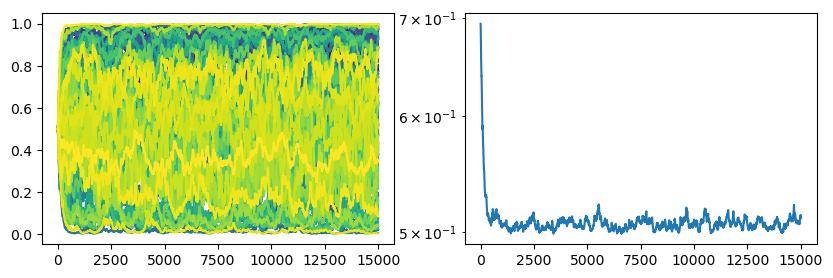

In [64]:
import matplotlib.pyplot as plt
import copy

plt.figure(figsize=(10,3))

cmap = plt.get_cmap('viridis') 

plt.subplot(1,2,1)

for i in range(n_task):
    plt.plot(task_abilities[:,i], color=cmap(i/(n_task-1)))
    
#plt.legend(np.arange(n_task))
    
#plt.xlim(1,300)
#plt.xscale('log')

plt.subplot(1,2,2)

losses1 = copy.deepcopy(losses)
plt.plot(losses1)
#plt.xscale('log')
plt.yscale('log')

task_abilities1 = copy.deepcopy(task_abilities)

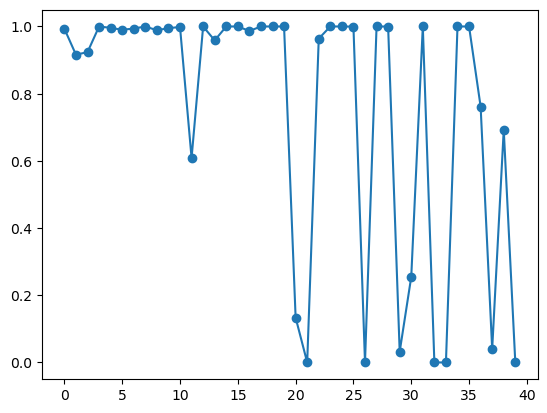

In [18]:
plt.plot(task_abilities[-1,:], marker='o')

In [27]:
losses1[6000]

0.1334795066206544

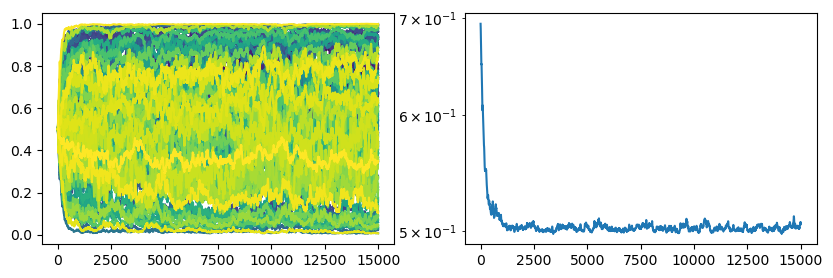

In [66]:
import matplotlib.pyplot as plt
import copy as copy

cmap = plt.get_cmap('viridis') 

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)

for i in range(n_task):
    plt.plot(task_abilities[:,i], color=cmap(i/(n_task-1)))
    
#plt.xlim(1,300)
#plt.xscale('log')
    
plt.subplot(1,2,2)

losses2 = copy.deepcopy(losses)
plt.plot(losses2)
#plt.xscale('log')
plt.yscale('log')


task_abilities2 = copy.deepcopy(task_abilities)

### Is this why you need learning rate warmup? 

In [68]:
losses3 = copy.deepcopy(losses)

In [71]:
losses4 = copy.deepcopy(losses)

In [74]:
losses5 = copy.deepcopy(losses)

(0.0, 10000.0)

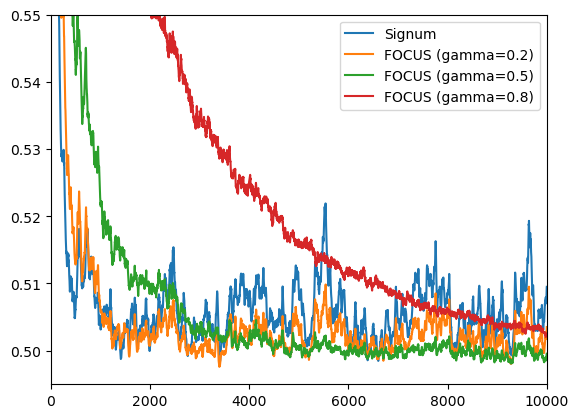

In [82]:
plt.plot(losses1)
plt.plot(losses2)
plt.plot(losses3)
plt.plot(losses4)
#plt.yscale('log')
#plt.title('gamma=0.1')
plt.legend(['Signum', 'FOCUS (gamma=0.2)', 'FOCUS (gamma=0.5)', 'FOCUS (gamma=0.8)'])
#plt.ylim(0,0.1)
plt.ylim(0.495,0.55)
plt.xlim(0,10000)

(-0.001, 0.001)

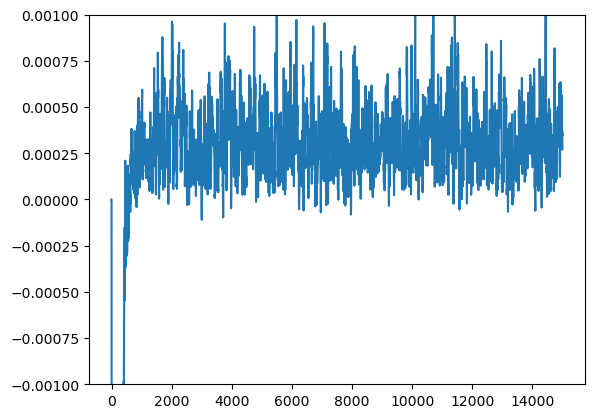

In [38]:
plt.plot(losses1-losses2)
plt.ylim(-0.001,0.001)

(0.1, 1.0)

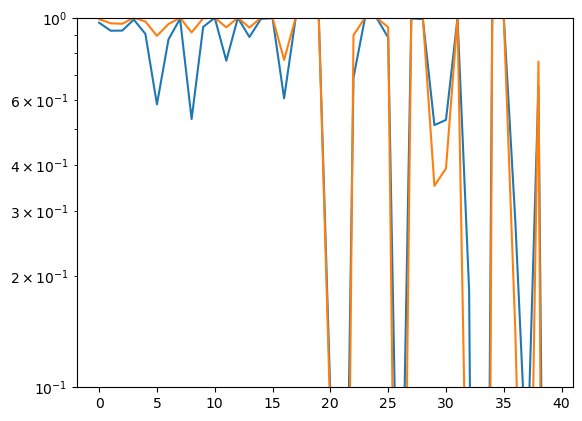

In [53]:

std1 = np.std(task_abilities1[-1000:,:], axis=0)
std2 = np.std(task_abilities2[-1000:,:], axis=0)
mean1 = np.mean(task_abilities1[-1000:,:], axis=0)
mean2 = np.mean(task_abilities2[-1000:,:], axis=0)
plt.plot(mean1)
plt.plot(mean2)
plt.yscale('log')
plt.ylim(0.1,1.0)

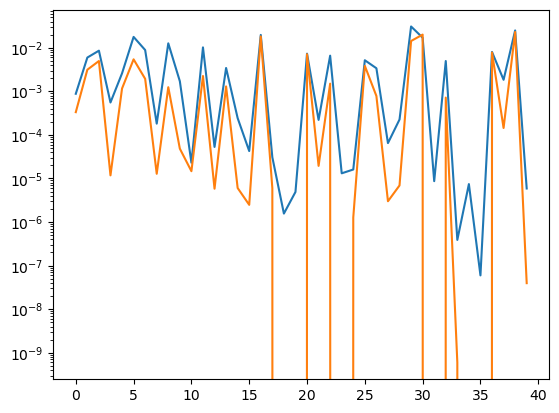

In [8]:
plt.plot(std1)
plt.plot(std2)
plt.yscale('log')

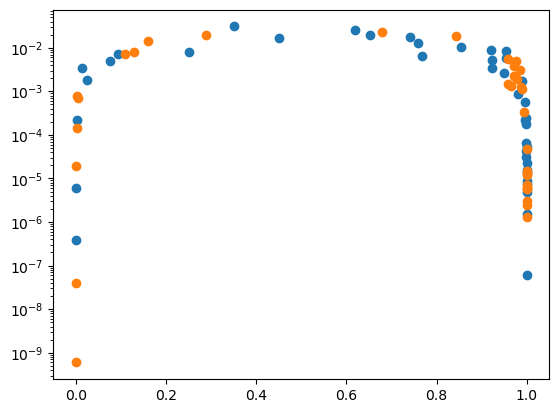

In [9]:
plt.scatter(mean1, std1)
plt.scatter(mean2, std2)
plt.yscale('log')

Text(0.5, 1.0, 'gamma=0.1')

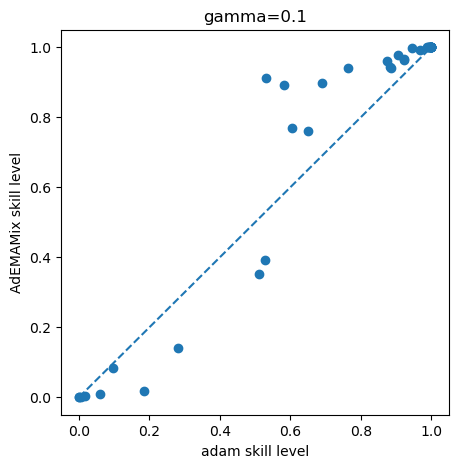

In [55]:
plt.figure(figsize=(5,5))
plt.scatter(mean1, mean2)
plt.plot([0,1],[0,1],ls='--')
plt.xlabel('adam skill level')
plt.ylabel('AdEMAMix skill level')
plt.title('gamma=0.1')

## Language models

(0.0, 90.0)

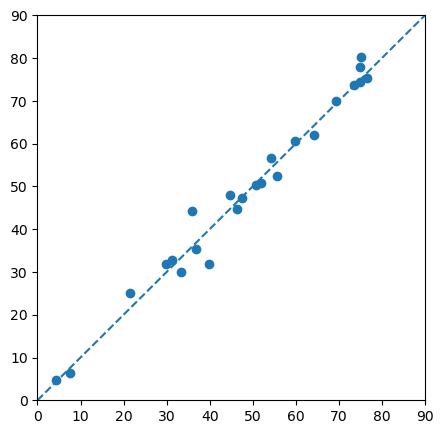

In [167]:
plt.figure(figsize=(5,5))

# 1.1B
ada = [21.5,4.3,7.5,50.7,74.8,75.1,59.7,52.0,36.8,69.4,64.3,31.2,44.8,54.3,75.0,55.6,47.6,35.9,76.5,73.4,46.4,33.3,39.8,29.8]
lion = [25.1,4.8,6.3,50.3,74.4,80.2,60.5,50.8,35.4,69.9,62.0,32.9,48.0,56.7,78.0,52.4,47.3,44.3,75.4,73.7,44.6,30.1,31.8,31.8]
ada = np.array(ada)
lion = np.array(lion)
plt.scatter(ada, lion)
#plt.scatter(ada, lion-ada)
plt.plot([0,100],[0,100],ls='--')
plt.xlim(0,90)
plt.ylim(0,90)

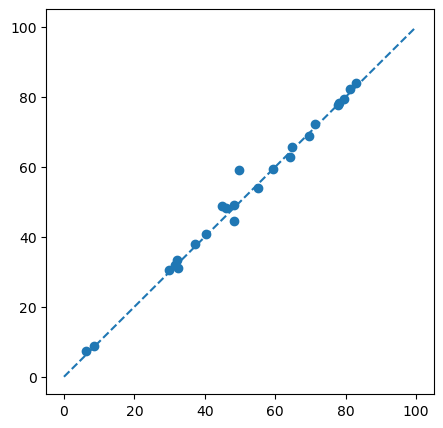

In [155]:
plt.figure(figsize=(5,5))

# 1.1B
ada = [32.0,6.3,8.4,59.4,78.2,81.3,64.8,55.1,40.3,71.3,69.5,37.3,48.4,64.1,83.0,49.8,46.1,45.0,79.6,77.8,48.2,32.4,29.8,31.4]
lion = [33.4,7.3,8.7,59.3,78.3,82.1,65.7,53.8,40.7,72.1,68.9,38.0,49.0,62.9,84.0,59.2,48.1,48.8,79.3,77.7,44.6,31.2,30.6,31.9]
plt.scatter(ada, lion)
plt.plot([0,100],[0,100],ls='--')

In [1]:
import torch
import numpy as np
from ademamix import AdEMAMix
from lion import Lion
from focus import FOCUS

n_tasks = [10,40]

noises = [0.0,0.2,1.0]

optims = ['adam', 'mix', 'lion']

results = {}

for n_task in n_tasks:
    for noise_scale in noises:
        for optim in optims:
        
            print(f'ntask={n_task}, noise_scale={noise_scale}, optim={optim}')

            seed = 7
            torch.manual_seed(seed)
            np.random.seed(seed)

            # get task vectors. all orthogonal
            dim = 10
            #n_task = 40

            # n_task = 10 can easily see why AdEMAMix accelerates with old momentum

            gaus = torch.randn(dim, dim)
            #u, s, v = torch.svd(gaus)

            # sweep noise scale is the most important 
            # Lion performs worse when noise is large

            # power law distribution
            alpha = 2
            prob = 1/(np.arange(n_task) + 1)**(alpha)
            prob /= np.sum(prob)


            #noise_scale = 0.2 # maybe due to non-linearity

            u = torch.randn(n_task, dim)/torch.sqrt(torch.tensor(dim))
            task_vectors = u[:n_task]


            batch_size = 128

            # initial and target
            x = torch.nn.Parameter(torch.zeros(dim,))

            learning_rate = 0.01
            #optimizer = torch.optim.SGD([x], lr=learning_rate)
            if optim == 'adam':
                optimizer = torch.optim.Adam([x], lr=learning_rate, betas=(0.9,0.95))
            elif optim == 'mix':
                optimizer = AdEMAMix([x], lr=learning_rate)
            elif optim == 'lion':
                optimizer = Lion([x], lr=learning_rate)
            else:
                pass
            
            #optimizer = FOCUS([x], lr=learning_rate, gamma=0.1)
            target = torch.sum(task_vectors, dim=0)


            n_steps = 15000
            log = 1000
            task_abilities = []
            losses = []
            losses_skill = []
            n_uses = []


            for i in range(n_steps):

                optimizer.zero_grad()

                # project and get progress
                task_overlap = task_vectors @ x
                task_ability = torch.sigmoid(task_overlap)

                loss = np.sum(-np.log(task_ability.detach().numpy()) * prob)
                task_abilities.append(task_ability.detach().numpy())
                losses.append(loss)
                losses_skill.append(1 - task_ability.detach().numpy())

                # mimic gradient
                id = np.random.choice(n_task, batch_size, p=prob)
                task_vectors_batch = task_vectors[id]
                task_ability_batch = task_ability[id]

                loss_per_sample = -torch.log(task_ability_batch)

                loss = torch.mean(loss_per_sample)
                loss.backward()
                x.grad.data += noise_scale * torch.randn(dim,)

                optimizer.step()

                neg_grad = - x.grad.detach()

                # compute #(used dimension)
                alignment = task_vectors * neg_grad[None, :] > 0
                n_used = torch.sum(alignment, dim=1)
                n_uses.append(n_used.detach().numpy())

                if i % log == 0:
                    print(i)

            task_abilities = np.array(task_abilities)
            losses = np.array(losses)
            n_uses = np.array(n_uses)
            losses_skill = np.array(losses_skill)

            results[f'loss_optim_{optim}_ntask_{n_task}_noise_{noise_scale}'] = losses
            results[f'skill_optim_{optim}_ntask_{n_task}_noise_{noise_scale}'] = task_abilities

ntask=10, noise_scale=0.0, optim=adam
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
ntask=10, noise_scale=0.0, optim=mix
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
ntask=10, noise_scale=0.0, optim=lion
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
ntask=10, noise_scale=0.2, optim=adam
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
ntask=10, noise_scale=0.2, optim=mix
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
ntask=10, noise_scale=0.2, optim=lion
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
ntask=10, noise_scale=1.0, optim=adam
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
ntask=10, noise_scale=1.0, optim=mix
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
ntask=10, noise_scale=1.0, optim=lion
0
1000
2000
3000
4000
5000
6000
7000
8000
900

In [2]:
np.savez('./results/optimizer', **results)

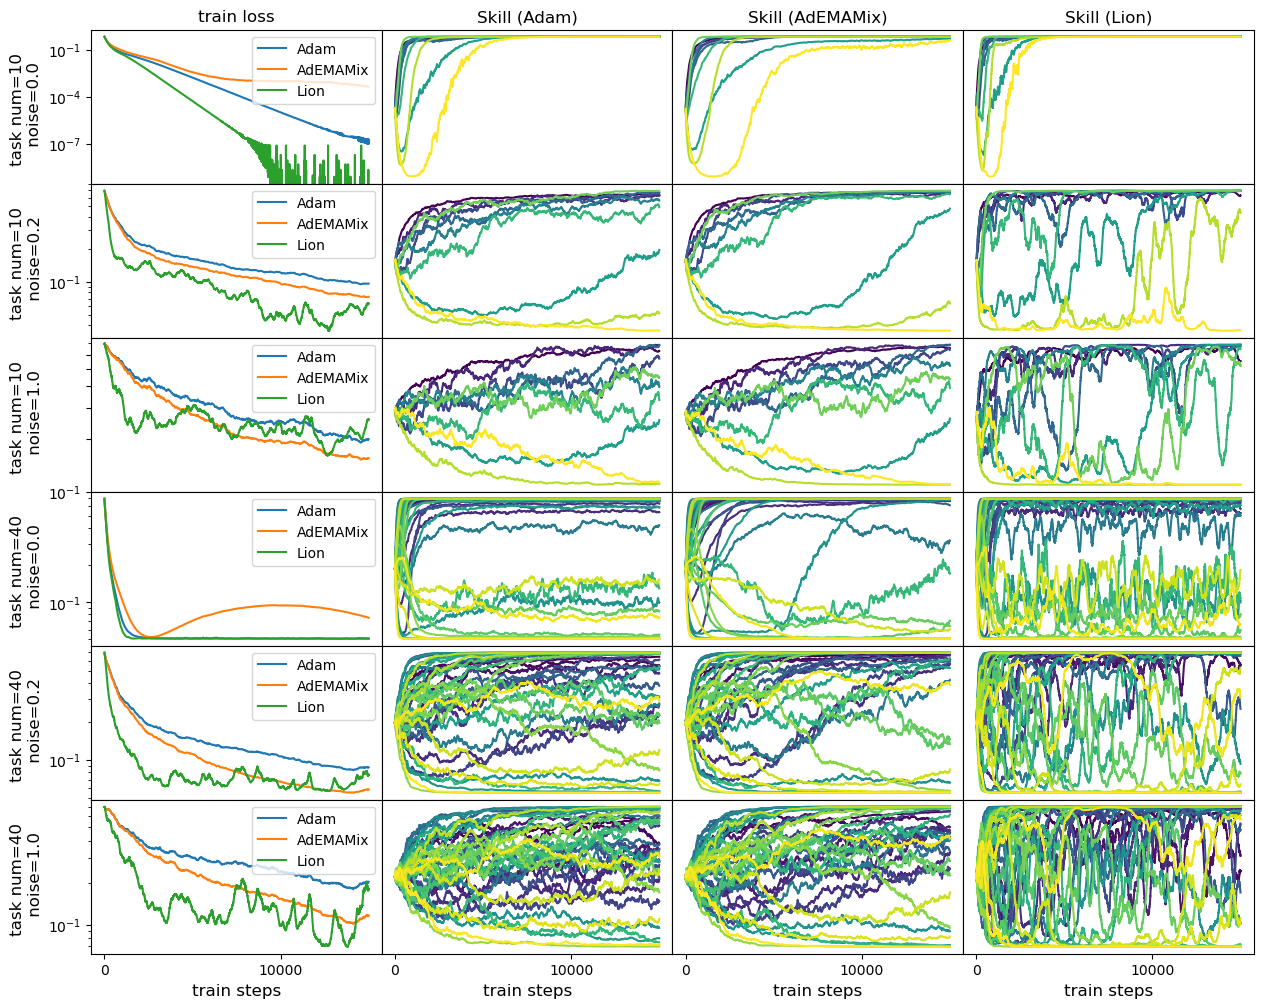

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,12))

n_tasks = [10, 40]
noise_scales = [0., 0.2, 1.0]

dic = dict(np.load('./results/optimizer.npz'))

optims = ['adam', 'mix', 'lion']

cmap = plt.get_cmap('viridis') 

for n_id in range(2):
    for noise_id in range(3):
        n_task = n_tasks[n_id]
        noise_scale = noise_scales[noise_id]
        
        row = n_id * 3 + noise_id
        n_prev = row * 4

        plt.subplot(6,4,1+n_prev)
        #n_task = 40
        #noise_scale = 0.2
        for optim in optims :
            plt.plot(dic[f'loss_optim_{optim}_ntask_{n_task}_noise_{noise_scale}'])

        plt.legend(['Adam', 'AdEMAMix', 'Lion'], loc='upper right')
        plt.yscale('log')

        if row == 5:
            plt.xlabel('train steps', fontsize=12)
        if row == 0:
            plt.title('train loss')
            
        if row == 5:
            plt.xticks([0,10000])
        else:
            plt.xticks([])
            
        if row == 2:
            plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6],[r'$10^{-1}$','','','','',''])
            
        plt.ylabel('task num={} \n noise={}'.format(n_task, noise_scale), fontsize=12)

        ii = 2
        for optim in optims:
            plt.subplot(6,4,ii+n_prev)

            task_abilities = dic[f'skill_optim_{optim}_ntask_{n_task}_noise_{noise_scale}']

            for i in range(n_task):
                plt.plot(task_abilities[:,i], color=cmap(i/(n_task-1)))

            if row == 0:
                if optim == 'mix':
                    plt.title('Skill (AdEMAMix)')
                elif optim == 'lion':
                    plt.title('Skill (Lion)')
                elif optim == 'adam':
                    plt.title('Skill (Adam)')

            if row == 5:
                plt.xlabel('train steps', fontsize=12)
            plt.yticks([])

            ii += 1

            if row == 5:
                plt.xticks([0,10000])
            else:
                plt.xticks([])

        #plt.suptitle('task num={}, noise={}'.format(n_task, noise_scale), fontsize=15, y=1.1)

plt.subplots_adjust(wspace=0, hspace=0.0)
plt.savefig('./plot/eff_optimizer.pdf', bbox_inches='tight')

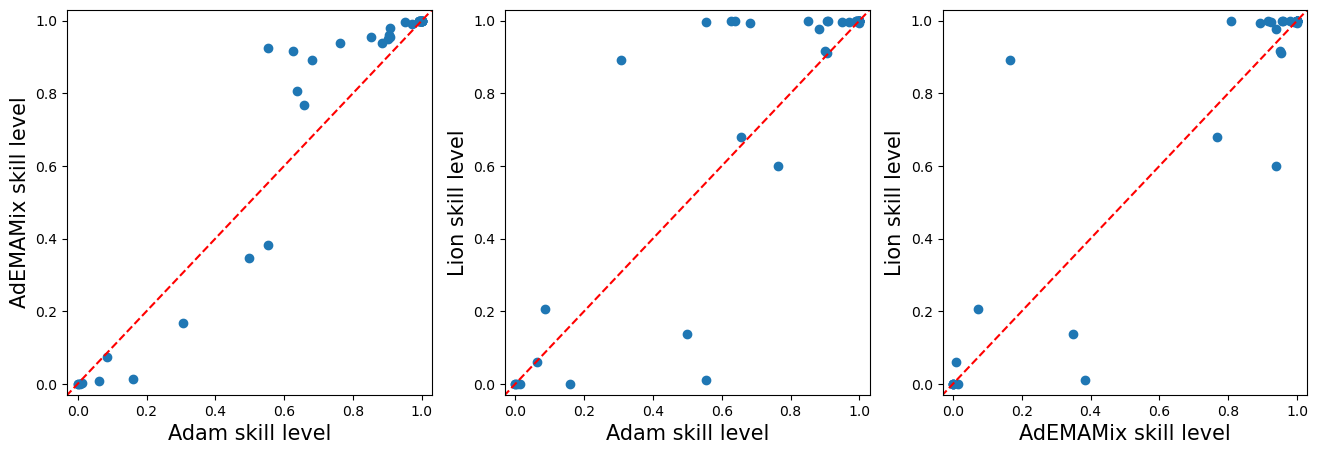

In [25]:
import numpy as np
import matplotlib.pyplot as plt

noise_scale = 0.2
n_task = 40

dic = dict(np.load('./results/optimizer.npz'))
adam = dic[f'skill_optim_adam_ntask_{n_task}_noise_{noise_scale}'][-1]
lion = dic[f'skill_optim_lion_ntask_{n_task}_noise_{noise_scale}'][-1]
mix = dic[f'skill_optim_mix_ntask_{n_task}_noise_{noise_scale}'][-1]

plt.figure(figsize=(16,5))

fontsize = 15

plt.subplot(1,3,1)
plt.scatter(adam, mix)
plt.plot([-0.1,1.1],[-0.1,1.1],ls='--', color='red')
plt.xlabel('Adam skill level', fontsize=fontsize)
plt.ylabel('AdEMAMix skill level', fontsize=fontsize)
plt.xlim(-0.03,1.03)
plt.ylim(-0.03,1.03)

plt.subplot(1,3,2)
plt.scatter(adam, lion)
plt.plot([-0.1,1.1],[-0.1,1.1],ls='--', color='red')
plt.xlabel('Adam skill level', fontsize=fontsize)
plt.ylabel('Lion skill level', fontsize=fontsize)
plt.xlim(-0.03,1.03)
plt.ylim(-0.03,1.03)

plt.subplot(1,3,3)
plt.scatter(mix, lion)
plt.plot([-0.1,1.1],[-0.1,1.1],ls='--', color='red')
plt.ylabel('Lion skill level', fontsize=fontsize)
plt.xlabel('AdEMAMix skill level', fontsize=fontsize)
plt.xlim(-0.03,1.03)
plt.ylim(-0.03,1.03)

plt.savefig('./plot/skill_compare_optimizer.pdf', bbox_inches='tight')